# SAT Scores and New York City Public Schools: What Affects a School's Results?

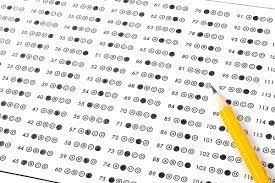

## Table of Contents:
* [Introduction](#first-bullet)
* [Data Preparation and Cleaning](#second-bullet)
* [Analysis: What factors correlate with a school's average SAT Scores?](#third-bullet)
* [Conclusion](#fourth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>
This analysis explores relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. We will combine multiple datasets together to get a good overall picture for each public high school in New York to see which factors potentially affect average SAT scores.

### The datasets:
* **SAT scores by school** - SAT scores for each high school in New York City
* **School attendance** - Attendance information for each school in New York City
* **Class size** - Information on class size for each school
* **AP test results** - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* **Graduation outcomes** - The percentage of students who graduated and other outcome information
* **Demographics** - Demographic information for each school
* **School survey** - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

For an additional bit of background, I was a teacher at a public high school for eight years in California. Where applicable I tried to use my prior experience for analytical insights.

## Data Preparation and Cleaning <a class="anchor" id="second-bullet"></a>
In this section I will be reading in the datasets, cleaning any necessary rows and columns, and then merging all of the separate datasets together in order to analyze based on a single dataframe.

### Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns
DBN is unique for each school and is present (in some form) in each original dataset. This makes it an ideal candidate to act as our key for merging the datasets together later on, but we need to make sure that all of the DBN columns/data look the same.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric
We want to create an overall "SAT Score" column to more easily look at SAT results (instead of needing to look at three separate sub-scores for each school). In order to make an `sat_score` column we first need to convert all subscores to numeric datatypes so that they can be added together.

We are also converting the coordinates for each school (latitude and longitude) to numeric data types in order to better represent geographic location for each school.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets
Many of the datasets contain more information than we need. We will limit our results to high school (because that's who takes the SAT) and the 2011-2012 schoolyear since that is the year we have SAT data for.

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analysis: What factors correlate with a school's average SAT Scores? <a class="anchor" id="third-bullet"></a>

### Find correlations

In [32]:
correlations = combined.corr()
correlations_asc = correlations["sat_score"].sort_values()
correlations_desc = correlations['sat_score'].sort_values(ascending=False)
print('Top 5 negative correlations:\n',correlations_asc.head())
print('\nTop 10 positive correlations:\n',correlations_desc.head(10))

Top 5 negative correlations:
 frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
Name: sat_score, dtype: float64

Top 10 positive correlations:
 sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
Name: sat_score, dtype: float64


As we can see from the correlations above, SAT sub-section scores heavily correlate with overall SAT score (which makes sense since the `sat_score` column was created from a sum of all 3 SAT subsections). Other than test subsections it looks like race, AP data, and socioeconomic indicators (`frl` (free and reduced lunch), `sped` (special education), and `ell` (english language learners)) are strong indicators of SAT results.

### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
survey_corrs = correlations[survey_fields].sort_values()

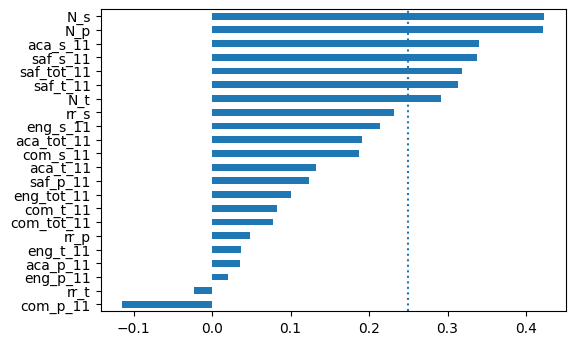

In [11]:
survey_corrs.plot.barh()
plt.axvline(0.25,linestyle=':')
plt.show()

Although the survey result correlations aren't as strong as the correlations above (AP, race, and socioeconomic indicators (SEI)) they are the best outlet into seeing student, teacher, and parent perception of lived experience within schools. Because of this, this could be very insightful information into why individuals schools with otherwise similar race/SEI perform better or worse on the SAT.

The dotted line above is a 'rough' cutoff at 0.25 to help distinguish correlations that are strong versus weak. We will only focus on variables above 0.25 for this analysis (there were no survey results below -0.25 otherwise those would also be included).

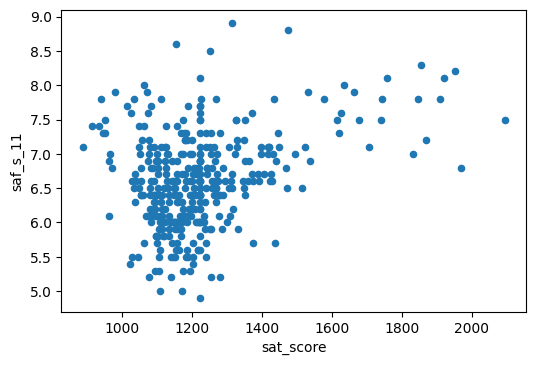

In [38]:
# Looking at student-perceived safety versus SAT scores:

combined.plot.scatter('sat_score','saf_s_11')
plt.show()

Survey fields with a correlation larger than +- 25%:
- **N_s**: Number of student repsondents
- **N_p**: Number of parent respondents
- **aca_s_11**: Academic expectations score based on student responses (11th grade)
- **saf_s_11**: Safety and Respect score based on student responses (11th grade)
- **saf_tot_11**: Safety and Respect score based on total responses (students, parents, and teachers)
- **saf_t_11**: Safety and Respect score based on teacher responses (11th grade)
- **N_t**: Number of teacher respondents

Overall it appears that student and parent engagement with the survey have large positive correlations with SAT scores. This makes sense since engaged students and parents are potentially more likely to also engage with SAT related activities (i.e. academics, prep courses) It also appears that the perception of safety and respect (school culture) plays a huge role amongst all educational actors (students, parents and teachers) in SAT scores.

Since safety seems to have a significant impact on SAT score, let's examine some possible reasons why safety scores may vary. One possibility is the area of New York that the school is in, so let's look at the five boroughs of New York in relation to safety scores and sat scores.

In [59]:
borough_safety = combined.groupby('boro').mean()
display(borough_safety[['saf_s_11','saf_p_11','saf_t_11','saf_tot_11','sat_score']].sort_values(by='sat_score'))

boro_corr = round(borough_safety['sat_score'].corr(borough_safety['saf_s_11']),2)
print('Correlation between borough and average SAT Score and Student Perception of Safety:', boro_corr)

,saf_s_11,saf_p_11,saf_t_11,saf_tot_11,sat_score
boro,,,,,
Bronx,6.606577,8.346237,7.026882,7.322581,1157.598203
Brooklyn,6.370755,8.036792,6.985849,7.129245,1181.364461
Manhattan,6.831370,8.288889,7.287778,7.473333,1278.331410
Queens,6.721875,8.098437,7.365625,7.387500,1286.753032
Staten Island,6.530000,7.800000,7.210000,7.200000,1382.500000


Correlation between borough and average SAT Score and Student Perception of Safety: 0.26


It is interesting to note that parents consistently rate safety at least a full-point higher than students and teachers.

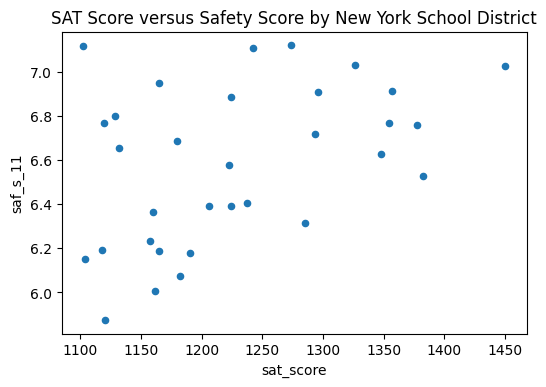

Correlation between school district average SAT Score and Student Perception of Safety: 0.43


In [56]:
district_safety = combined.groupby(['school_dist','boro']).mean()
dist_boro = district_safety[['saf_s_11','saf_p_11','saf_t_11','saf_tot_11','sat_score']].sort_values(by='saf_tot_11')
dist_boro.plot.scatter('sat_score','saf_s_11')
plt.title('SAT Score versus Safety Score by New York School District')
plt.show()

dist_corr = str(round(dist_boro['sat_score'].corr(dist_boro['saf_s_11']),2))
print("Correlation between school district average SAT Score and Student Perception of Safety:",dist_corr)

This guided project asked to assess safety by borough, but New York boroughs are huge and diverse. Some of the [most dangerous neighborhoods in 2011](https://www.businessinsider.com/most-dangerous-neighborhoods-in-new-york-2011-9#1-midtown-10) (when this sat and school data was collected) were scattered amongst several different boroughs, so concluding that this survey question was about borough-level safety perception doesn't make sense.

Since the official survey question was asking about "Safety *and* Respect" I think it is much more likely that it was considering school-level safety than borough-level safety. Instead it may be helpful to look at school district in comparison to safety scores since those a bit more granular and neighborhoods can affect school culture more more than a large borough.

**We can see the difference in strength of these relationships by the respective correlations. Safety/SAT for borough is 0.26 whereas Safety/SAT for district is 0.43.**

### SAT Scores and Racial Makeup of Schools
Since race had a very strong correlation for SAT scores let's take a closer look:

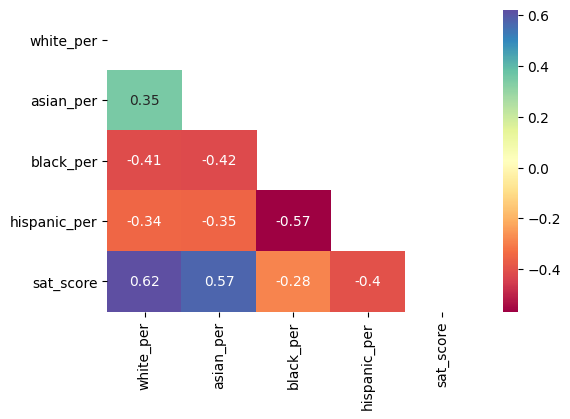

In [15]:
import seaborn as sns

race_percents = ['white_per','asian_per','black_per','hispanic_per']
race_percents_sat = ['white_per','asian_per','black_per','hispanic_per','sat_score']

mask = numpy.triu(numpy.ones_like(combined[race_percents_sat].corr()))
sns.heatmap(combined[race_percents_sat].corr(),annot=True, mask=mask,cmap='Spectral')
plt.show()

The correlation matrix above shows that there are very substantial positive and negative correlations between race and sat score, with high percentages of white/asian students positively correlating with sat scores and high percentages of black/hispanic students negatively correlating with sat scores.

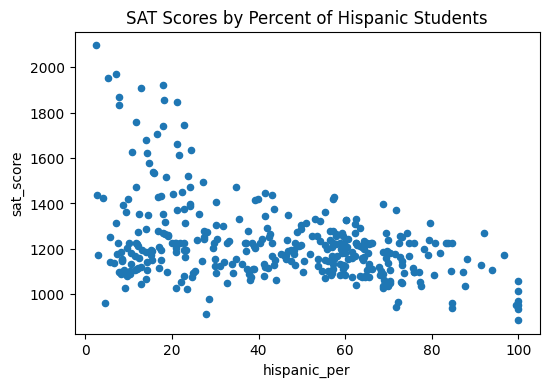

In [16]:
# Hispanic SAT score scatter plot:

combined.plot.scatter('hispanic_per','sat_score')
plt.title('SAT Scores by Percent of Hispanic Students')
plt.show()

In the scatterplot above we can see that some of the lowest SAT averages come from schools that report 100% of students as being hispanic.

In [17]:
combined[['SCHOOL NAME','Num of SAT Test Takers','hispanic_per','sat_score','sped_percent','ell_percent','school_dist','boro','saf_s_11']][combined['hispanic_per']>95]

,SCHOOL NAME,Num of SAT Test Takers,hispanic_per,sat_score,sped_percent,ell_percent,school_dist,boro,saf_s_11
44,MANHATTAN BRIDGES HIGH SCHOOL,66,99.8,1058.0,1.7,72.6,02,Manhattan,7.2
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,96.7,1174.0,18.1,19.6,06,Manhattan,7.5
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,99.8,1014.0,0.0,89.6,06,Manhattan,7.7
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,99.4,951.0,0.9,86.6,09,Bronx,7.5
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,99.8,934.0,4.6,79.9,10,Bronx,7.4
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,99.8,970.0,0.2,92.9,12,Bronx,6.8
253,MULTICULTURAL HIGH SCHOOL,29,99.8,887.0,1.0,94.6,19,Brooklyn,7.1
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,100.0,951.0,0.8,91.3,24,Queens,7.3


As we can see in the graph above, schools that have 95%+ hispanic students also tend to have very high levels of EL (English Learner) students. The one exception to this is [Washington Heights Expeditionary Learning School](https://www.wheelsnyc.net/we_are_crew). They are part of the NYC Outward Bound program, which focuses on EL (English Learner) Education, **but interestingly, 97% of students are hispanic but only 20% are identified as English Learners. This is an anomaly compared to other schools with 95%+ hispanic percentages, which all have significantly higher levels of EL students**

In [18]:
combined[['SCHOOL NAME','Num of SAT Test Takers','hispanic_per','sat_score','sped_percent','ell_percent','school_dist','boro','saf_s_11']][(combined['hispanic_per']<10) & (combined['sat_score']>1800)]

,SCHOOL NAME,Num of SAT Test Takers,hispanic_per,sat_score,sped_percent,ell_percent,school_dist,boro,saf_s_11
37,STUYVESANT HIGH SCHOOL,832,2.4,2096.0,0.4,0.0,02,Manhattan,7.5
151,BRONX HIGH SCHOOL OF SCIENCE,731,7.2,1969.0,0.1,0.1,10,Bronx,6.8
187,BROOKLYN TECHNICAL HIGH SCHOOL,1277,7.9,1833.0,0.5,0.1,13,Brooklyn,7.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,7.9,1868.0,0.2,0.2,28,Queens,7.2
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,5.3,1953.0,0.5,0.1,31,Staten Island,8.2


All 5 of the schools with very high average SAT scores and low (less than 10%) hispanic student populations are part of New York city's ["Specialized High Schools (SHS)" program](https://www.schools.nyc.gov/enrollment/enroll-grade-by-grade/specialized-high-schools) which caters to academically gifted students. Although SHS does have a [Diversity Initiative](https://www.schools.nyc.gov/enrollment/enrollment-help/meeting-student-needs/diversity-in-admissions) it is not mandatory and the five schools listed above are not currently participating in the diversity initiative.

### Gender and SAT Scores

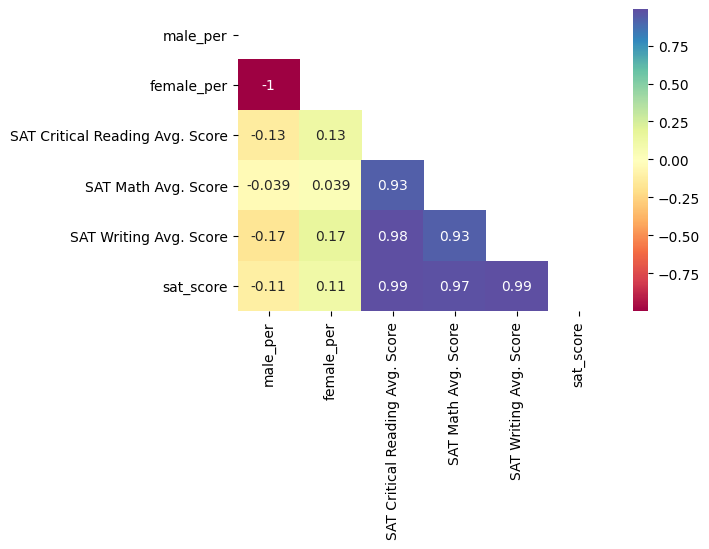

In [19]:
gender_percents = ['male_per','female_per','SAT Critical Reading Avg. Score','SAT Math Avg. Score',
                   'SAT Writing Avg. Score','sat_score']

mask = numpy.triu(numpy.ones_like(combined[gender_percents].corr()))
sns.heatmap(combined[gender_percents].corr(),annot=True, mask=mask,cmap='Spectral')
plt.show()

When investigating gender percentages and correlation with SAT scores I wanted to include the test subtypes because historically girls have not done as well on the math portion of the exams as boys. Although the correlation map above shows generall weak correlations between SAT and gender, there is a notable difference of 10%+ in correlations between the gender percents in reading/writing versus math. The pure -1 correlation for male percent vs female percent makes sense given that `female_per` is a perfect inverse of `male_per` (since total student percent in this dataset consists of males+females)

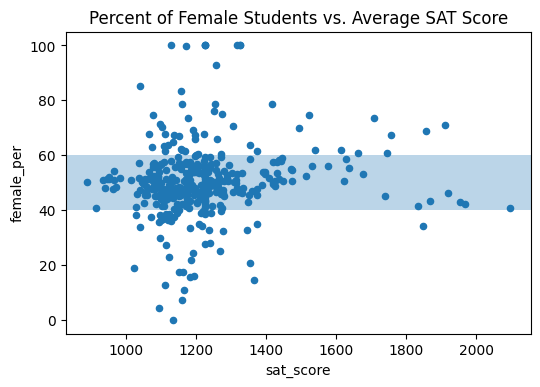

In [20]:
combined.plot.scatter('sat_score','female_per')
plt.axhspan(40,60,alpha=0.3)
plt.title('Percent of Female Students vs. Average SAT Score')
plt.show()

In [66]:
fem_60 = round(combined['sat_score'][combined['female_per']>60].mean(),2)
fem_40 = round(combined['sat_score'][combined['female_per']<40].mean(),2)
print("Average SAT Score for schools with more than 60% female: ",fem_60)
print("Average SAT Score for schools with less than 40% female: ",fem_40)

Average SAT Score for schools with more than 60% female:  1287.69
Average SAT Score for schools with less than 40% female:  1188.92


The blue highlighted bar indicates an estimated 'normal' range for a mixed-gender school, which makes sense why there is a large cluster of dots in that region. At a quick glance it appears that schools with a higher percentages (60%+) of girls tend to do slightly better on average on the SAT than schools with a lower percentage of girls (less than 40%). When breaking this down by mean we can see that **schools with more than 60% female students do about 100 points better on the SAT than schools with less than 40% female students.**

Let's investigate the schools with more than 60% girls:

In [21]:
combined[['SCHOOL NAME','SAT Critical Reading Avg. Score','SAT Math Avg. Score',
                   'SAT Writing Avg. Score','sat_score','female_per','sped_percent','ell_percent','school_dist','boro','saf_s_11']][(combined['female_per']>60) & (combined['sat_score']>1700)]

,SCHOOL NAME,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,female_per,sped_percent,ell_percent,school_dist,boro,saf_s_11
5,BARD HIGH SCHOOL EARLY COLLEGE,624.0,604.0,628.0,1856.0,68.7,0.8,0.2,01,Manhattan,8.3
26,ELEANOR ROOSEVELT HIGH SCHOOL,572.0,594.0,592.0,1758.0,67.5,1.2,0.2,02,Manhattan,8.1
60,BEACON HIGH SCHOOL,577.0,575.0,592.0,1744.0,61.0,3.7,0.2,03,Manhattan,7.8
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,566.0,564.0,577.0,1707.0,73.6,1.0,0.2,03,Manhattan,7.1
302,TOWNSEND HARRIS HIGH SCHOOL,621.0,651.0,638.0,1910.0,71.1,0.2,0.0,25,Queens,7.8


Of the five schools that have high average SAT scores and high percentages of female students all appear to be part of New York's "Screened high school" program where some kind of academic admissions screening is required for admittance.

### AP Test Takers in Relation to SAT Scores

In [22]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

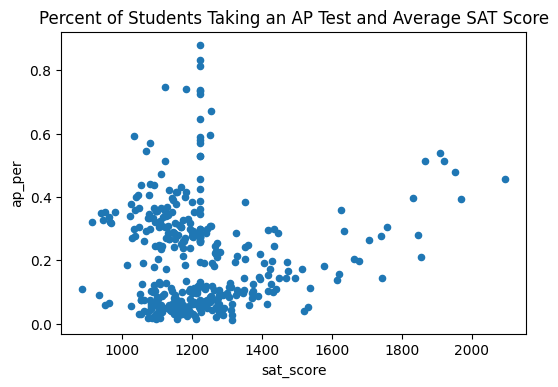

In [23]:
combined.plot.scatter('sat_score','ap_per')
plt.title('Percent of Students Taking an AP Test and Average SAT Score')
plt.show()

**Note that the vertical line at ~1220 is the dataset mean for SAT score. This value was used to fill in any schools with missing SAT scores.

In [24]:
combined[['sat_score','ap_per']].corr()

,sat_score,ap_per
sat_score,1.000000,0.057171
ap_per,0.057171,1.000000


With a correlation coefficient of 0.05, there is no apparent correlation between sat score and the percent of AP test takers. Let's examine the AP test taker percent for schools with the highest average SAT scores and the lowest average SAT scores:

In [25]:
# Highest average SAT scores:

combined[['SCHOOL NAME','sat_score','ap_per']][combined['sat_score']>1700].sort_values(by='sat_score')

,SCHOOL NAME,sat_score,ap_per
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,0.265259
198,"BROOKLYN LATIN SCHOOL, THE",1740.0,0.275703
60,BEACON HIGH SCHOOL,1744.0,0.142857
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,0.305720
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,0.397037
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,0.280788
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,0.209123
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,0.514354
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,0.537719
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,0.514589


In [26]:
combined[['SCHOOL NAME','sat_score','ap_per']][combined['sat_score']<1000].sort_values(by='sat_score')

,SCHOOL NAME,sat_score,ap_per
253,MULTICULTURAL HIGH SCHOOL,887.0,0.108374
225,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,913.0,0.321768
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,0.090759
179,HIGH SCHOOL OF WORLD CULTURES,939.0,0.349672
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,945.0,0.328318
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,0.059524
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,0.352538
139,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,962.0,0.064386
237,IT TAKES A VILLAGE ACADEMY,963.0,0.337772
126,BRONX INTERNATIONAL HIGH SCHOOL,965.0,0.320171


There does not appear to be a correlation between the percent of students that take an AP test and the school's average SAT score. From my personal experience as a high school teacher many students were encourages (or in some school instances even required) to take AP courses despite not necessarily being prepared for the academic rigor.

## Conclusion <a class="anchor" id="fourth-bullet"></a>

* Student perception of school safety and respect varies widely by school district, which as a strong correlation with district average SAT Score.
* Schools with high percentages of English Language Learners have lower average SAT scores.
* New York Specialized High Schools (SHS's) seem to have above-average SAT scores, but SHS's that do not participate in the Diversity Initiative have very low percentages of Hispanic students
* Schools with more than 60% of female students perform better on the SAT than schools with less than 40% female students.
* Schools with high percentages of female students and high SAT scores are generally part of New York's "Screened High School" program, where academic testing is required for admittance.
* The percent of total AP test takers by school does not seem to correlate with SAT scores.

### Next Steps:
This dataset has a number of potential areas for further explorations. As a former math teacher I would want to look at the relationship of English Language Learners and their SAT subsection scores to see if the math exam scores are higher than the reading and writing section, since math can be much more universal than an english-language-based reading and writing exam.

The SAT has also been often scrutinized by education advocates as unfair to historically disadvantaged groups and fewer colleges are now requiring SAT scores than before. I am curious to see if this has any affect on (1) SAT scores by school and (2) AP Test results by school.